## Add libraries

In [1]:
# Before running the code i had to download ipykernel
import os
import mne
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from mne.preprocessing import ICA, create_eog_epochs
#from mne.connectivity import spectral_connectivity #Not working anymore
from mne_connectivity import spectral_connectivity_epochs as spectral_connectivity  #The function was also renamed slightly
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm # Shows a progress bar
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import spectrogram
from itertools import combinations
print(sys.executable)
#%matplotlib notebook
%matplotlib inline


c:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\.venv-gpu\Scripts\python.exe


## Load & combine data by task for 1 subject

Subject 1 data was loaded & combined based on the task
imagined dataset : runs 4, 8, 12
actual movement dataset: runs 3, 7, 11

In [2]:

def process_and_save_subject_task(subject_id, task_name, runs, base_raw_path, base_output_path):
    """
    Loads raw runs for a subject/task, combines them, and saves the result.
    """
    print(f"--- Processing Subject {subject_id}, Task: {task_name} ---")

    # 1. Load and Combine the raw data
    subject_folder = f"S{subject_id:03d}"
    subject_folder_path = os.path.join(base_raw_path, subject_folder)
    
    raw_files = []
    for run_number in runs:
        file_name = f"{subject_folder}R{run_number:02d}.edf"
        file_path = os.path.join(subject_folder_path, file_name)
        raw = mne.io.read_raw_edf(file_path, preload=True, stim_channel='auto')
        raw_files.append(raw)
        
    raw_combined = mne.concatenate_raws(raw_files)

    # 2. Define the output path and save the file
    output_folder = os.path.join(base_output_path, subject_folder)
    os.makedirs(output_folder, exist_ok=True)
    
    output_filename = f"{subject_folder}_{task_name}_raw.fif"
    output_path = os.path.join(output_folder, output_filename)
    
    raw_combined.save(output_path, overwrite=True)
    print(f"✅ Saved combined data to: {output_path}\n")

# --- Configuration ---
base_raw_path = r"C:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\Datasets\raw"
base_output_path = r"C:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\Datasets\processed"

TASK_RUNS = {
    'imagined_movement': [4, 8, 12],
    'actual_movement': [3, 7, 11]
}

# --- Now, you can easily process multiple subjects in a loop ---
# Let's process the first 3 subjects as an example
for subject in range(1, 2):
    process_and_save_subject_task(
        subject_id=subject,
        task_name='imagined_movement',
        runs=TASK_RUNS['imagined_movement'],
        base_raw_path=base_raw_path,
        base_output_path=base_output_path
    )
    process_and_save_subject_task(
        subject_id=subject,
        task_name='actual_movement',
        runs=TASK_RUNS['actual_movement'],
        base_raw_path=base_raw_path,
        base_output_path=base_output_path
    )

--- Processing Subject 1, Task: imagined_movement ---
Extracting EDF parameters from C:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\Datasets\raw\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\Datasets\raw\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\Datasets\raw\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Overwriting existing file.
Writing C:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\Datasets\processed\S001\S001_imagined_movement_raw.fif

## Use concatonated data

Load & prepare the reorganised and concatonated data for understanding

In [3]:
subject_id = 1
task_name = 'imagined_movement'

base_output_path = r"C:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\Datasets\processed"
subject_folder = f"S{subject_id:03d}"
processed_file = os.path.join(base_output_path, subject_folder, f"{subject_folder}_{task_name}_raw.fif")

raw = mne.io.read_raw_fif(processed_file, preload=True)

print(raw.info)
print(f"Data Duration: {raw.times[-1]/60:.2f} minutes")


Opening raw data file C:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\Datasets\processed\S001\S001_imagined_movement_raw.fif...
Isotrak not found
    Range : 0 ... 59999 =      0.000 ...   374.994 secs
Ready.
Reading 0 ... 59999  =      0.000 ...   374.994 secs...
<Info | 10 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, last_name: X, sex: 0>
>
Data Duration: 6.25 minutes


## Channel Names & 2D montage

Clean channel names & set a 2D montage (togographical map of nodes)

missing positions will be in middle of diagram []


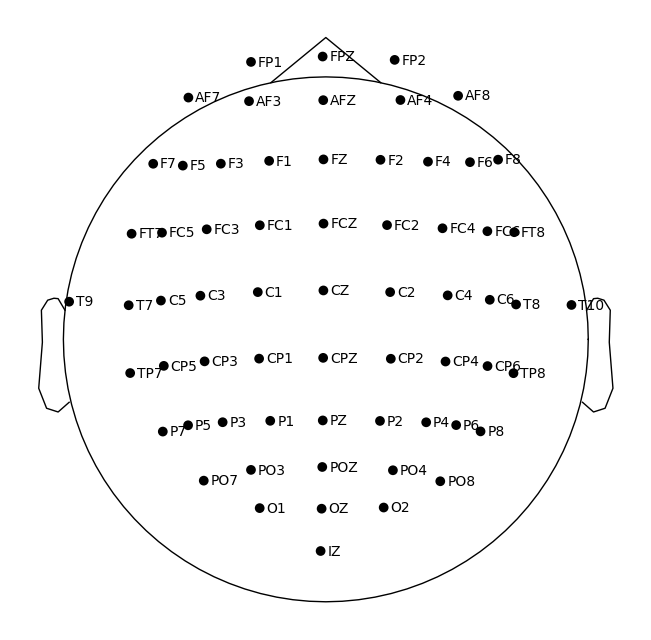

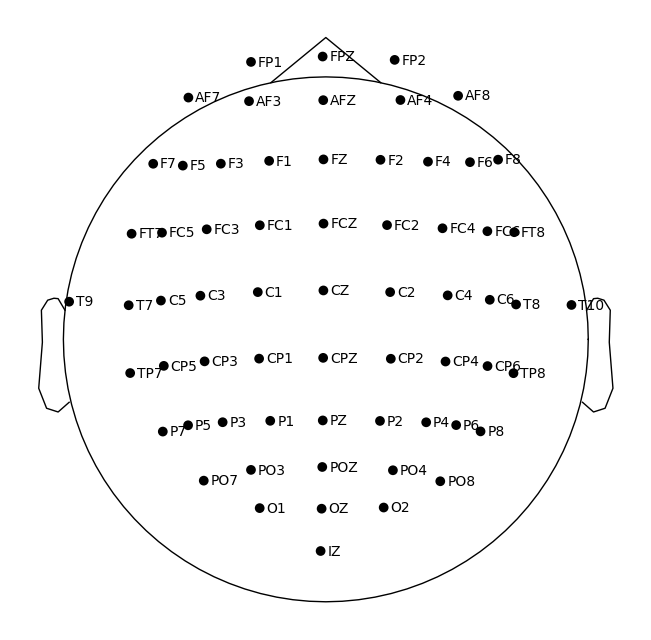

In [4]:
raw.rename_channels(lambda name: name.replace('.', '').strip().upper())

raw.set_channel_types({ch: 'eeg' for ch in raw.ch_names})

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, match_case=False, match_alias=True, on_missing='warn')

missing_positions= []

for ch in raw.info['chs']:
    if np.allclose(ch['loc'][:3], 0.0):
        missing_positions.append(ch['ch_name'])

print("missing positions will be in middle of diagram", missing_positions)


raw.plot_sensors(show_names=True) # 2D montage

## 3D montage

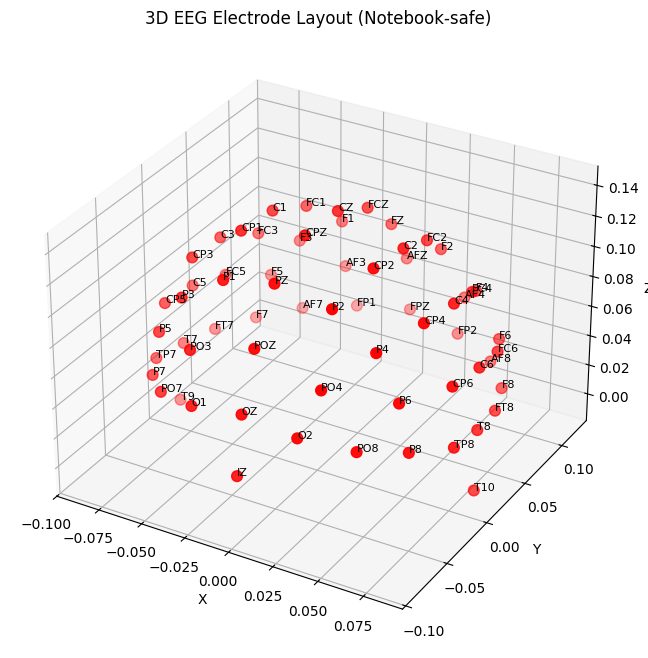

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np



# Extract channel positions
pos = np.array([ch['loc'][:3] for ch in raw.info['chs']])
names = raw.ch_names

# Create 3D figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot electrode positions
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=60, c='r')

# Add channel names as labels
for i, name in enumerate(names):
    ax.text(pos[i, 0], pos[i, 1], pos[i, 2], name, fontsize=8)

# Axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("3D EEG Electrode Layout (Notebook-safe)")

plt.show()


## EEG Signal Visualisation (Raw & Spectral Analysis)

Visualise the EEG data 

Grab Plotting of all regions before filtering
1. Visualise raw EEG signal in time domain.
2. Visualise the power spectral density of the EEG signal (how signal power is distributed across different frequncy)

Showing all channels together...
Using matplotlib as 2D backend.


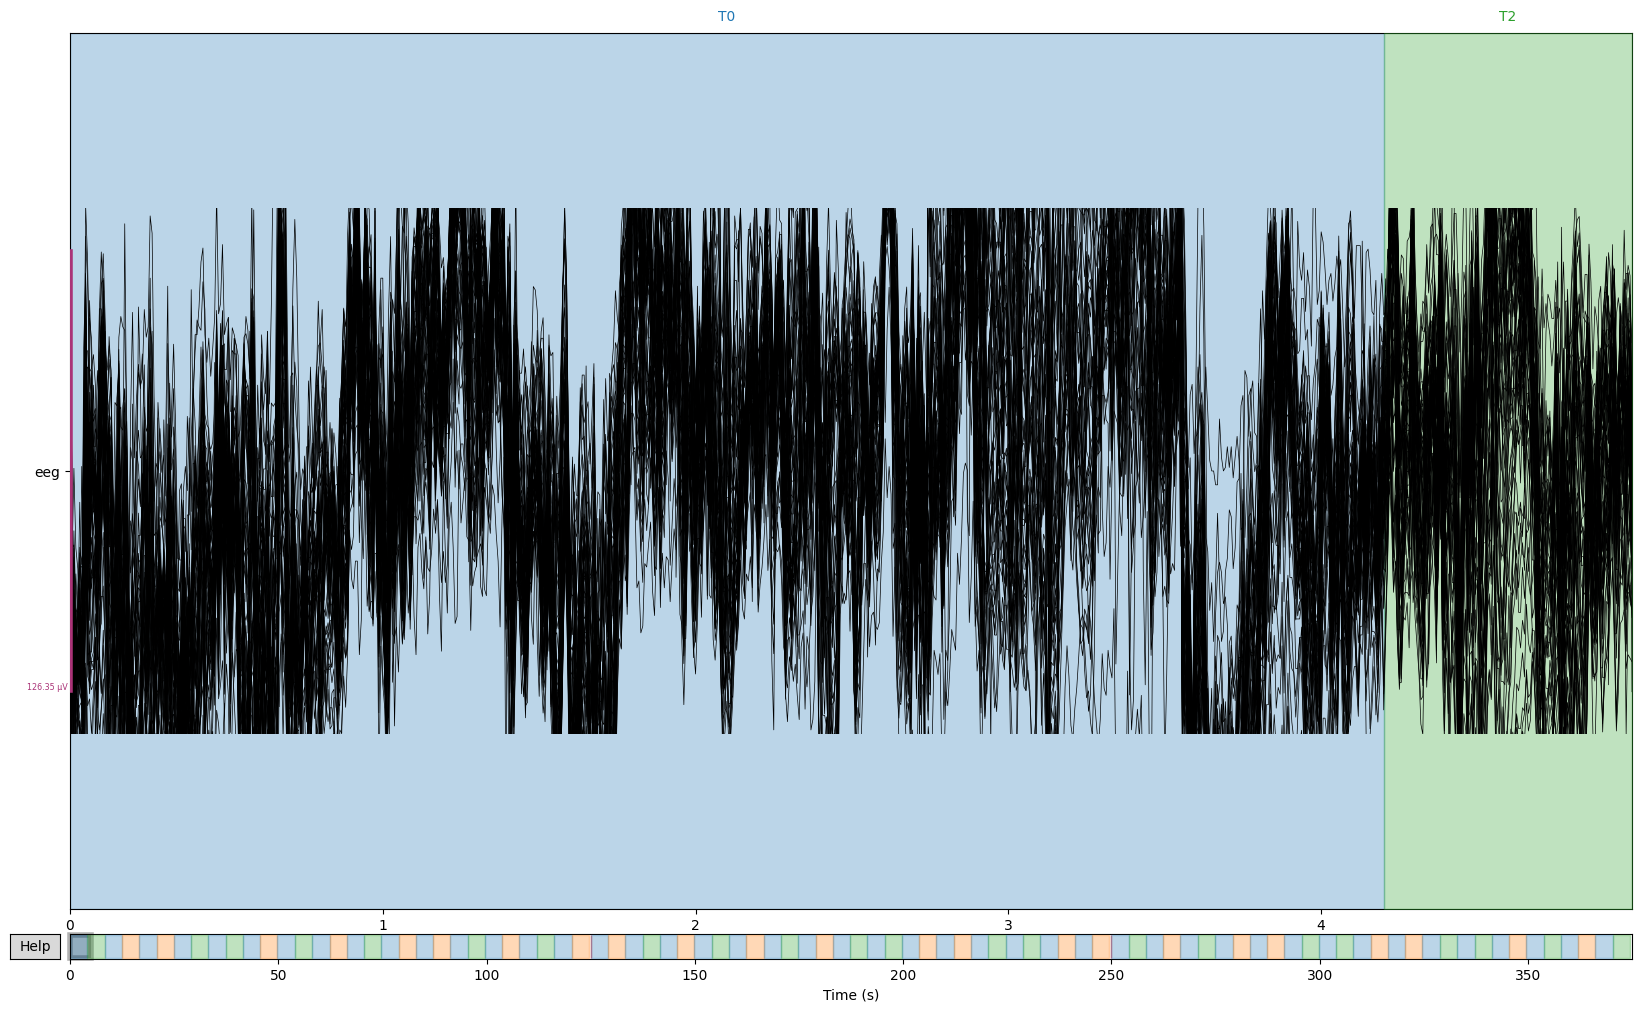

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
Showing channels in their own categories
--- Frontal Channels ---


c:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\.venv-gpu\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


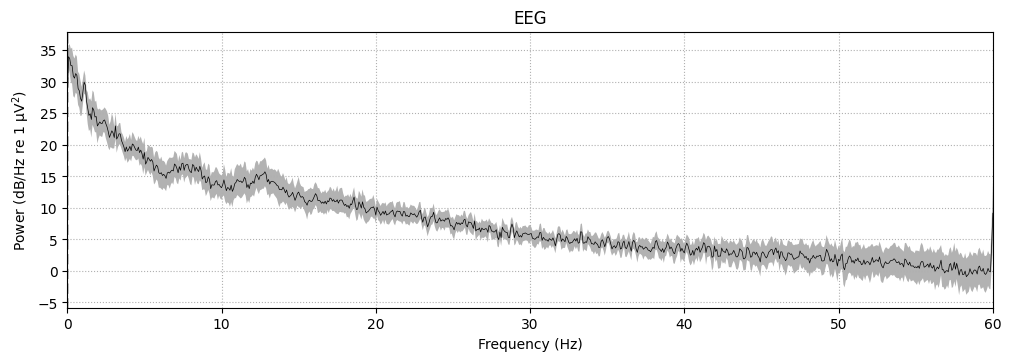

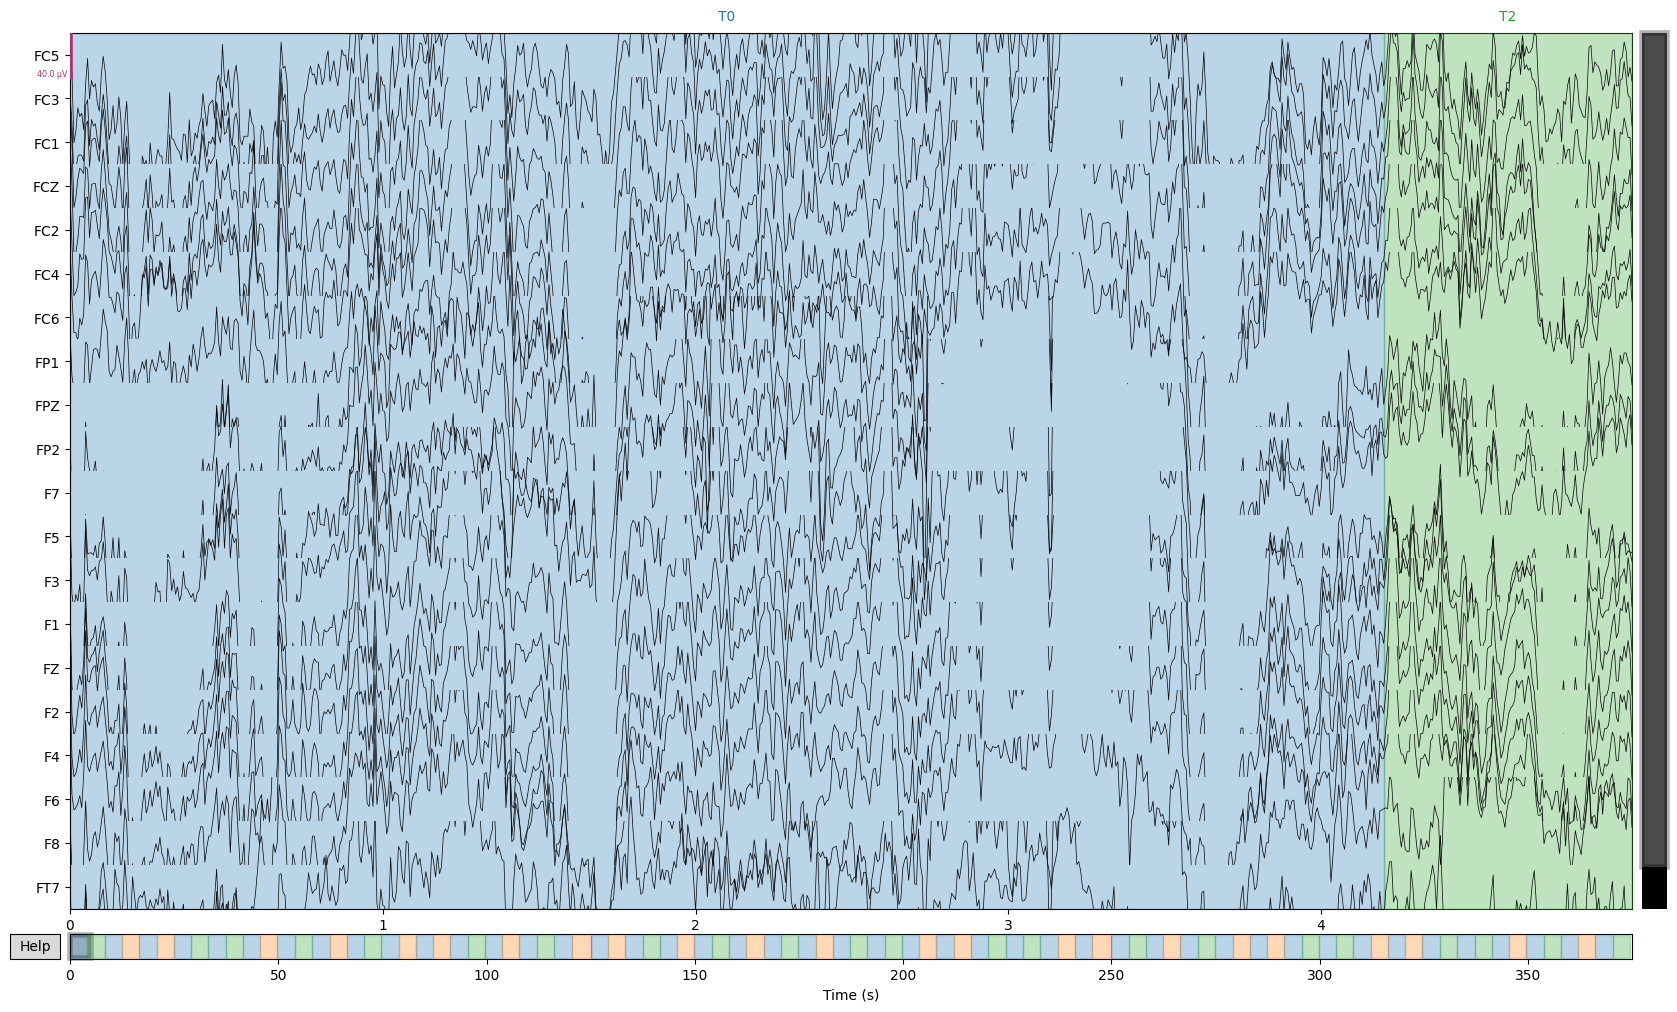

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
--- Central Channels ---


c:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\.venv-gpu\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


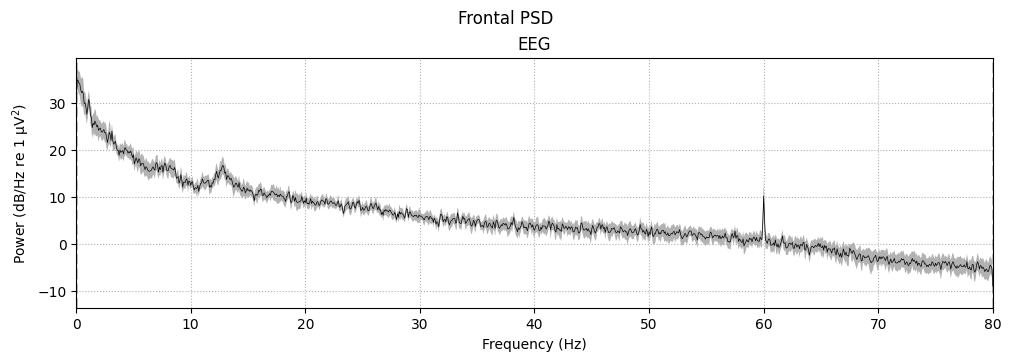

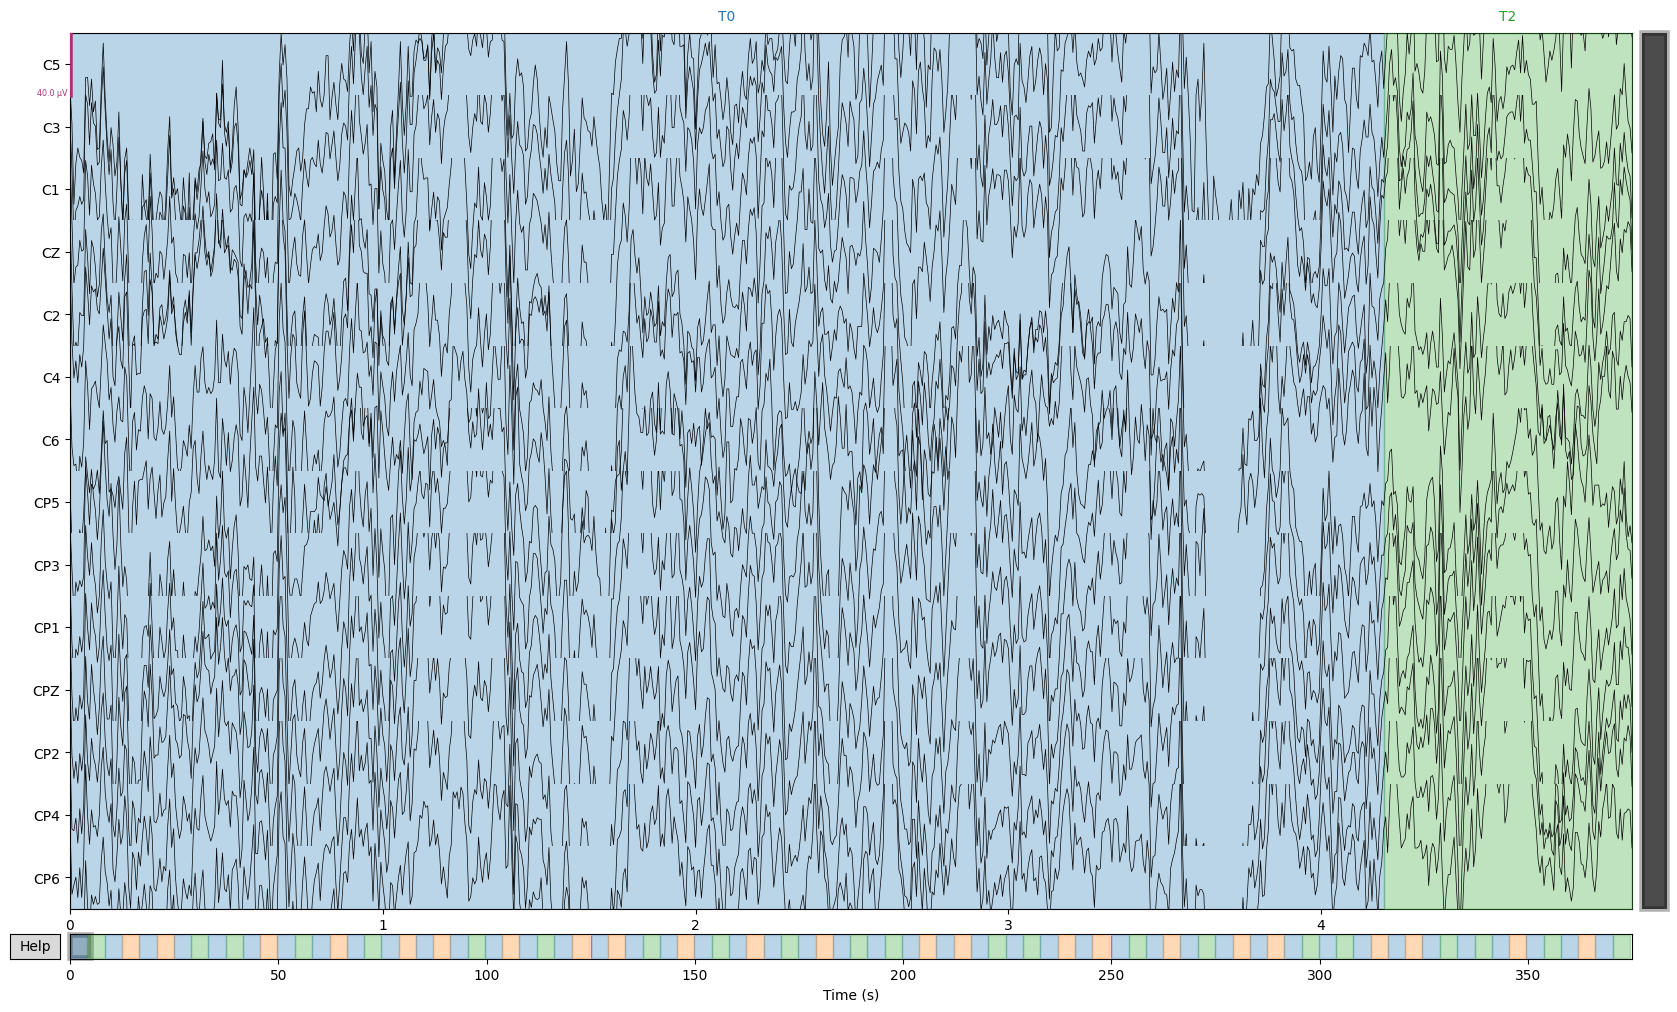

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
--- Parietal Channels ---


c:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\.venv-gpu\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


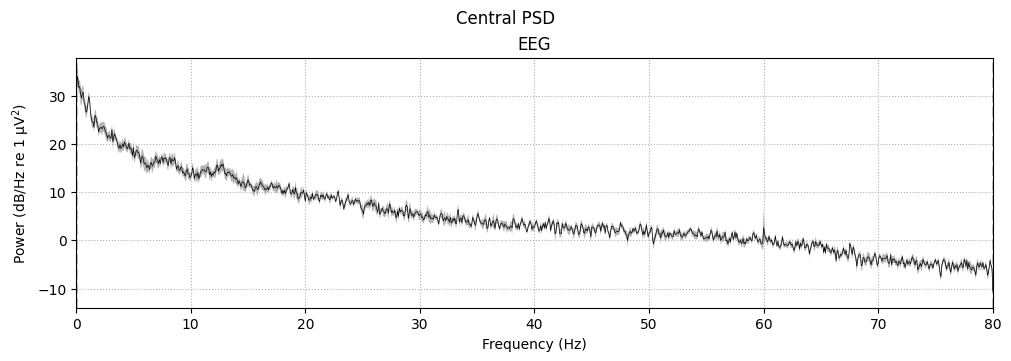

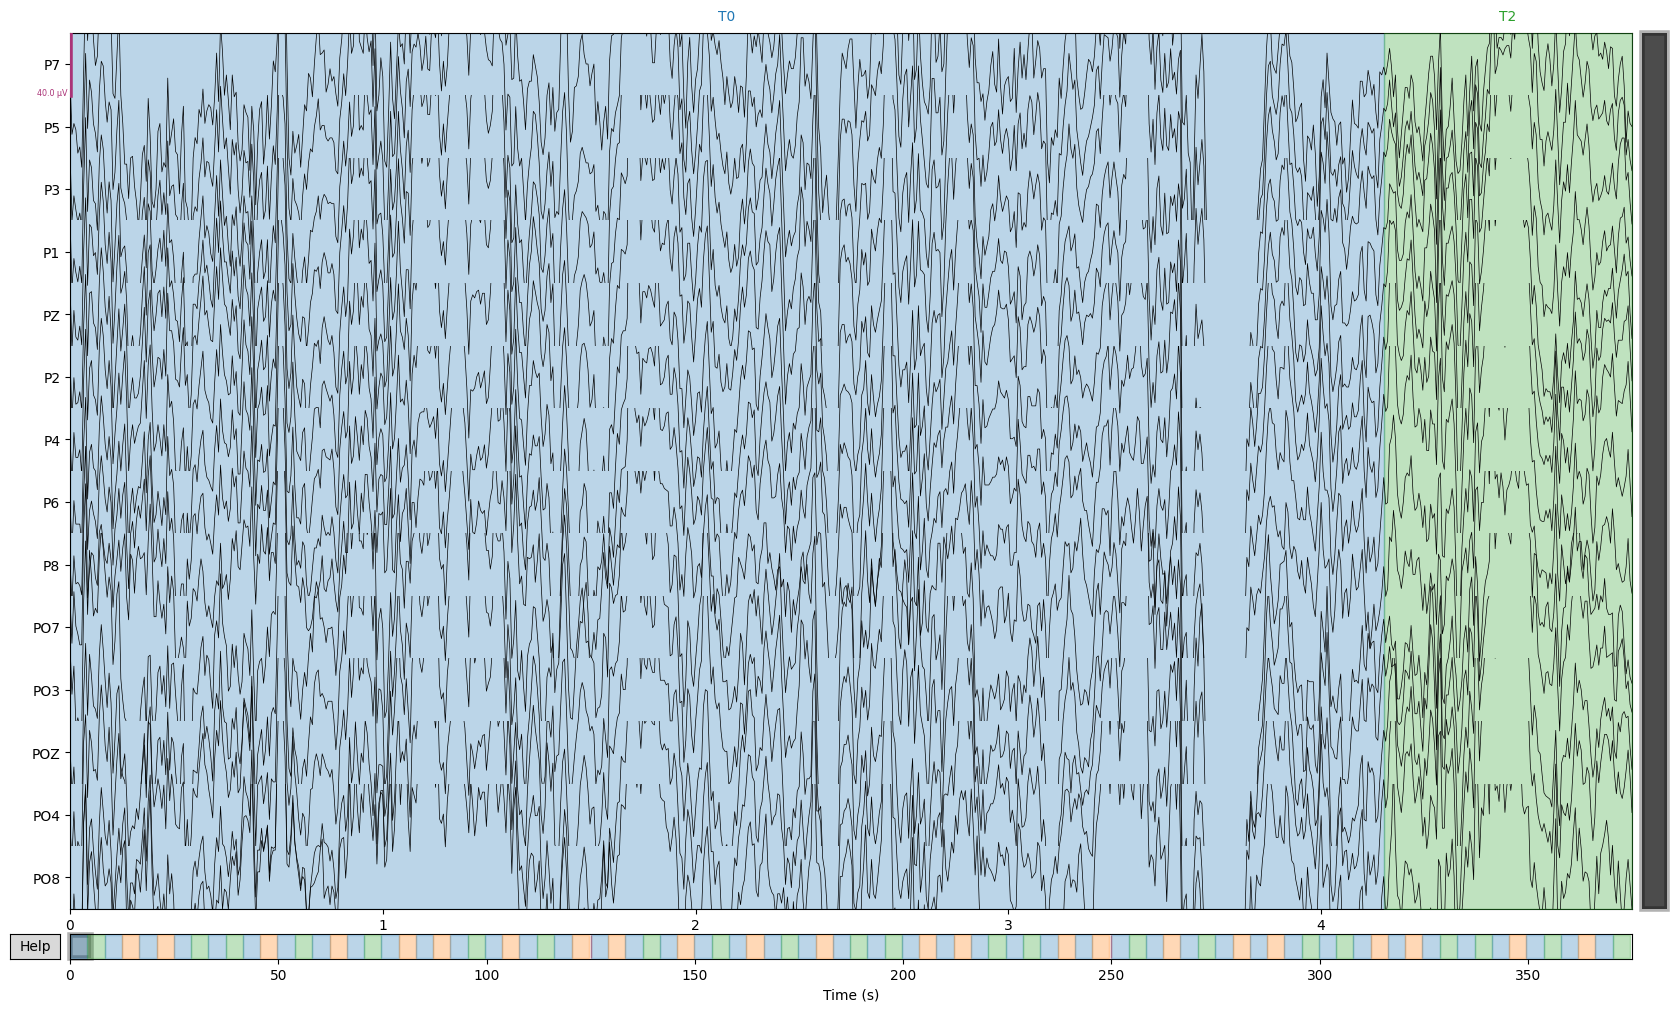

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
--- Occipital Channels ---


c:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\.venv-gpu\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


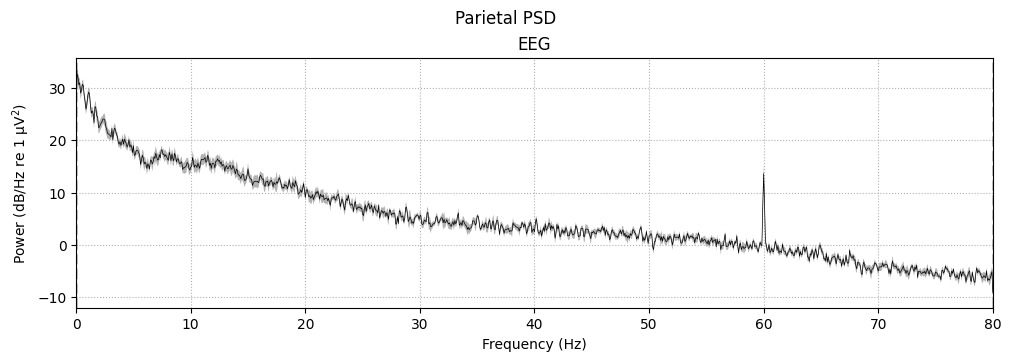

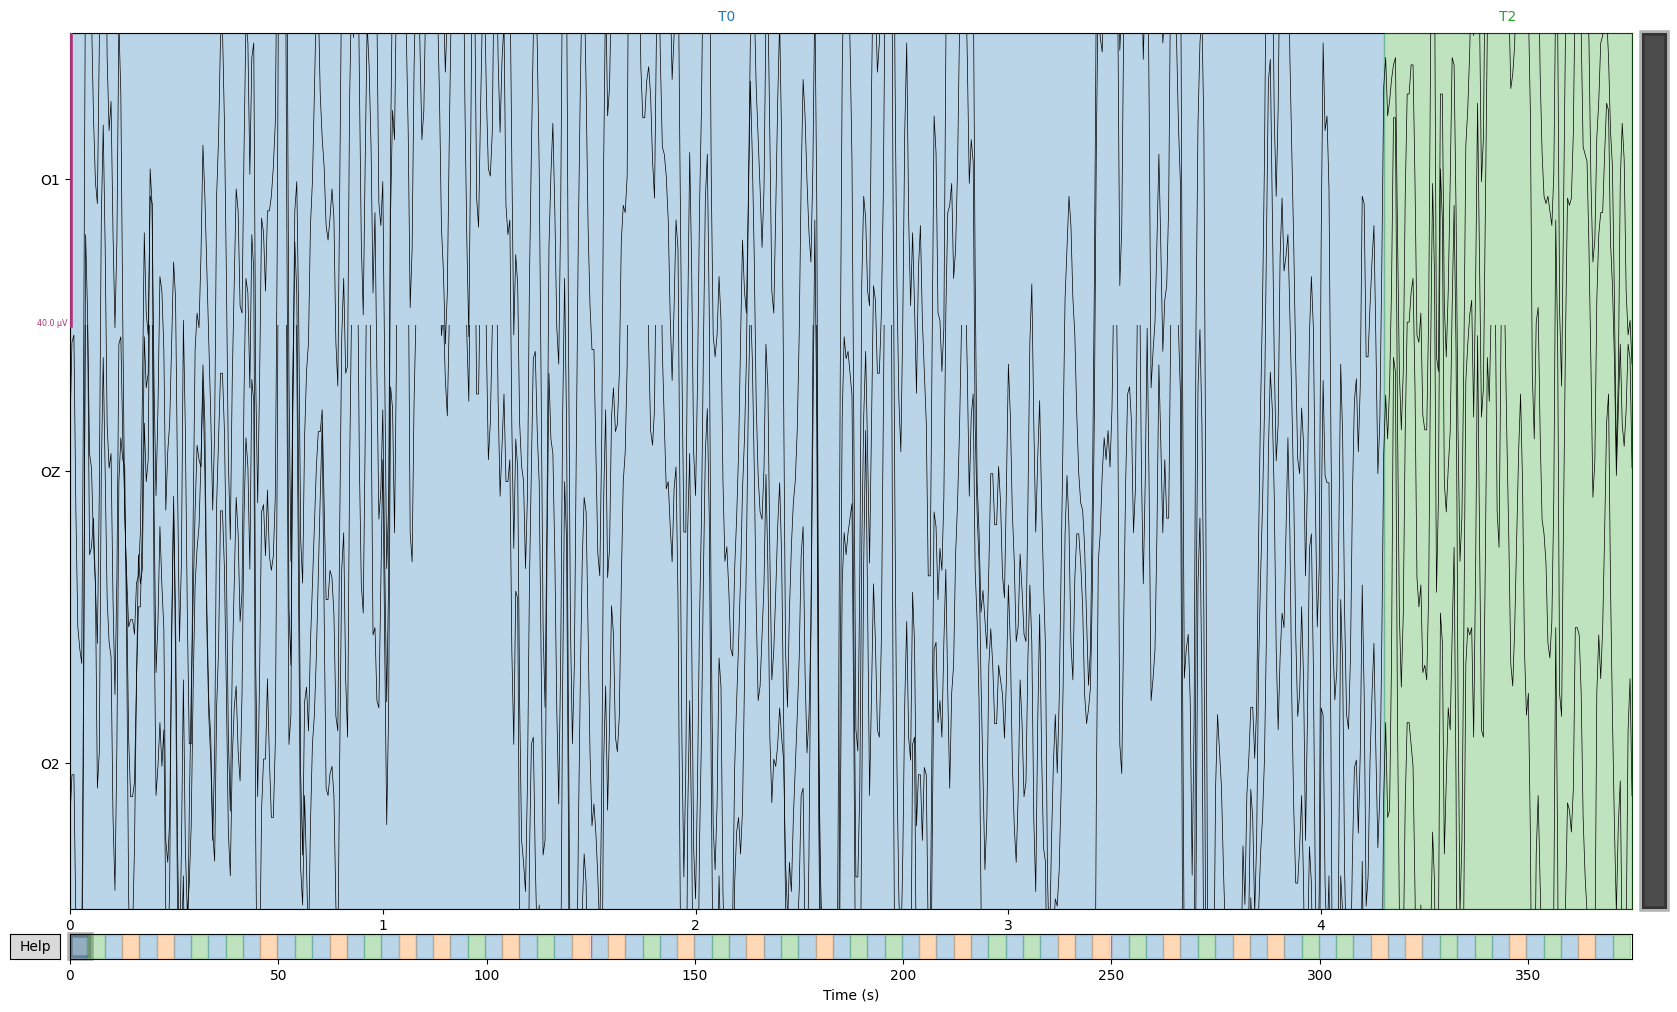

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
--- Temporal Channels ---


c:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\.venv-gpu\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


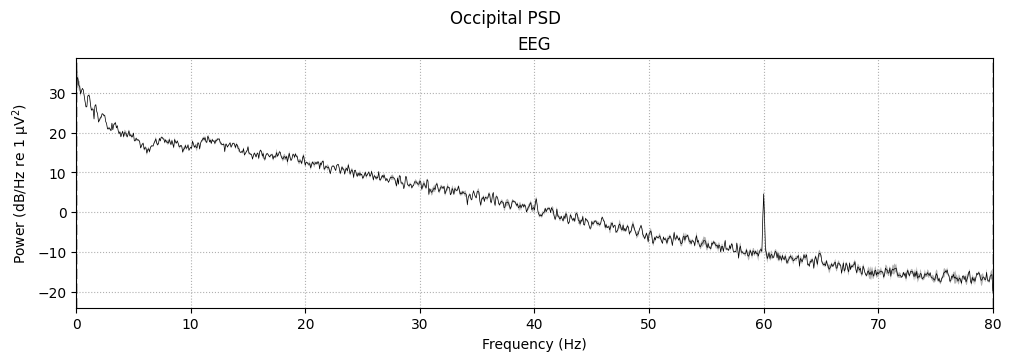

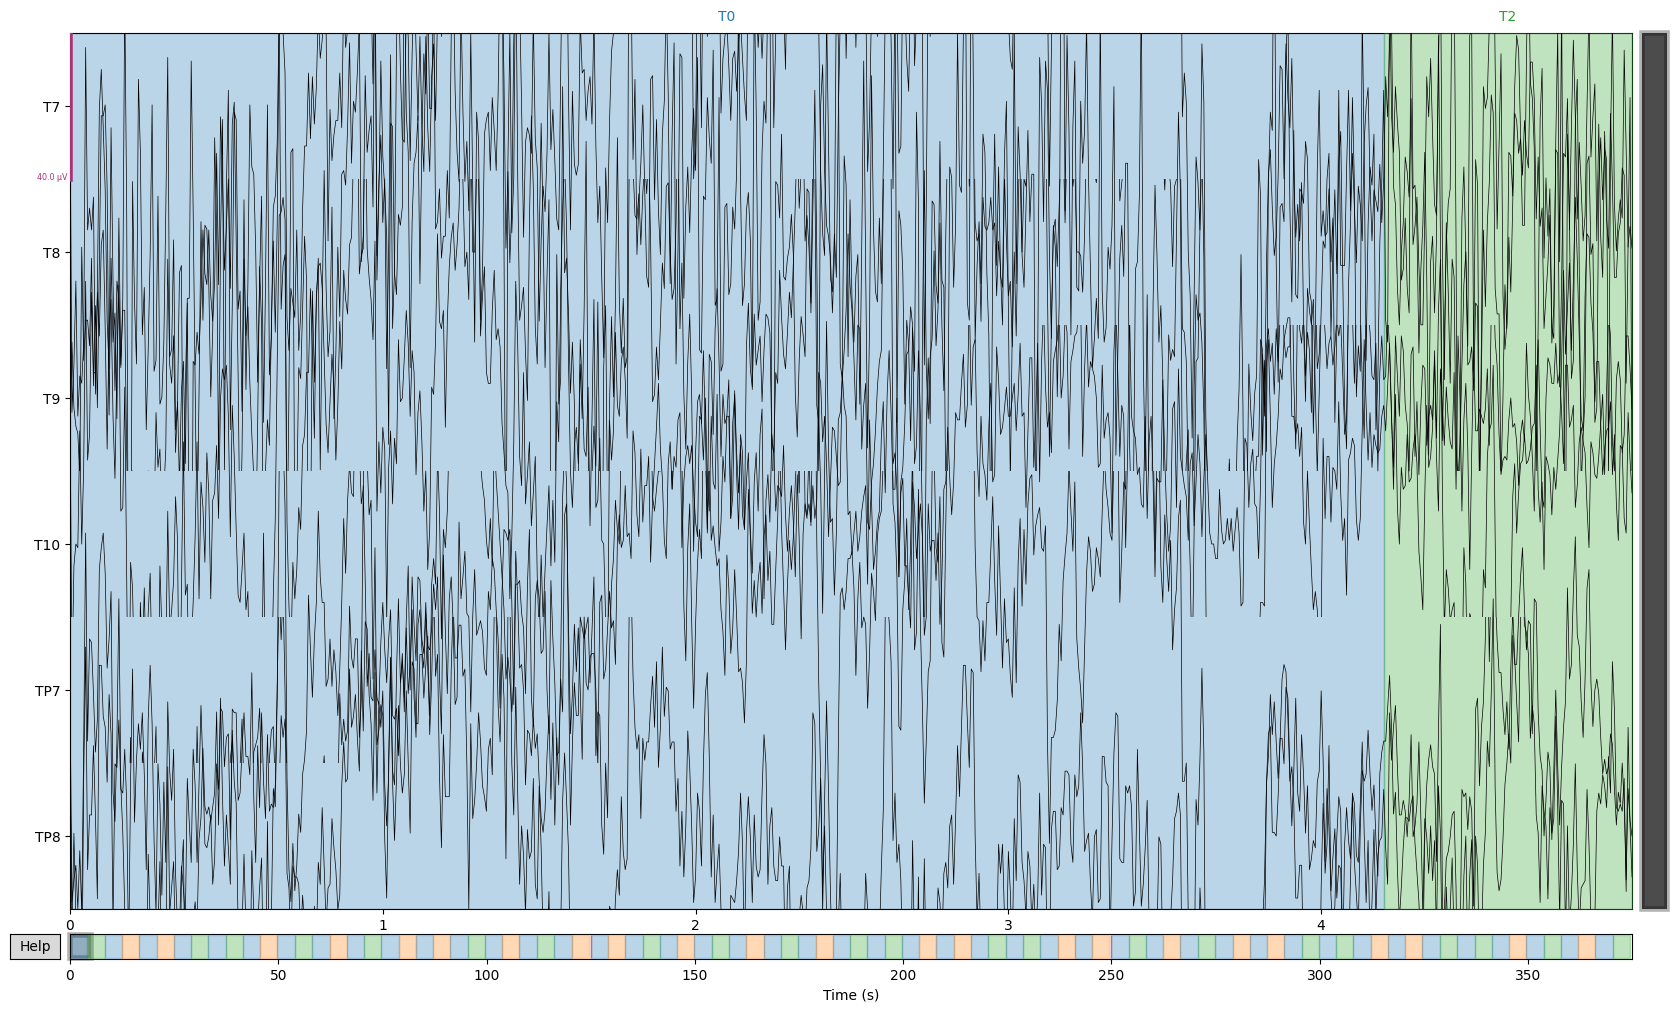

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


c:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\.venv-gpu\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


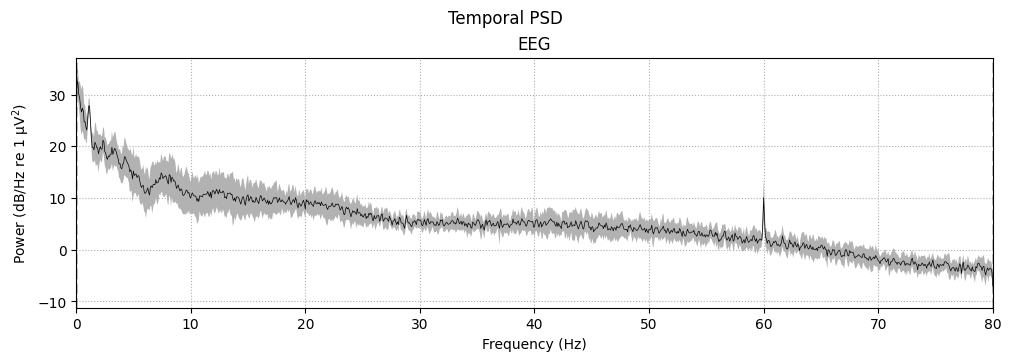

In [6]:
def plot_eeg_overview(raw_obj):
    print("Showing all channels together...")
    raw.plot(
        duration=5,            # how many seconds per screen
        n_channels=len(raw.ch_names),  # display all channels
        scalings='auto',       # automatically scale signal amplitude
        title='All EEG Channels',
        butterfly=True         # overlay channels for better comparison
    )

    psd = raw.compute_psd(fmax=60)
    psd.plot(picks="eeg", exclude = "bads", average = True, dB = True)
    # Pick - picks what type of signal it has to plot; eeg signal
    # exlude - do not include bad channels
    # average -

    print("Showing channels in their own categories")
    channel_subgroups = {
        "Frontal": [ch for ch in raw.ch_names if ch.startswith(("F", "Fp"))],
        "Central": [ch for ch in raw.ch_names if ch.startswith("C")],
        "Parietal": [ch for ch in raw.ch_names if ch.startswith("P")],
        "Occipital": [ch for ch in raw.ch_names if ch.startswith("O")],
        "Temporal": [ch for ch in raw.ch_names if ch.startswith(("T", "Tp"))]
    }

    for region, channels in channel_subgroups.items():
        if channels:
            print(f"--- {region} Channels ---")
            
            # Raw signal plot
            raw.plot(picks=channels, duration=5, title=f"{region} EEG Channels")
            
            # PSD plot
            psd = raw.compute_psd(picks=channels)
            fig = psd.plot(average=True, dB=True)  # Remove 'title'
            fig.suptitle(f"{region} PSD")           # Set title manually


    plt.show()
plot_eeg_overview(raw)


## Bandpass Filtering & Notch Filter
-Remove slow drifts (DC offsets) & high-frequency noise.

From above, line noise is observed at the 60Hz mark thus a notch filter was used

l_freq = 1 : High-pass filter at 1Hz
h_freq = 40: Low-pass filter at 40Hz

In [7]:
raw_filtered = raw.copy().filter(l_freq=1., h_freq=40.)
raw_filtered.notch_filter(freqs=[50])

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband ed

<Raw | S001_imagined_movement_raw.fif, 64 x 60000 (375.0 s), ~29.4 MiB, data loaded>

Replots the channels & PSD to view the effects of the Bandpass & Notch Filter.

In [ ]:
plot_eeg_overview(raw_filtered)

Showing all channels together...


## ICA pipeline

In [ ]:
ica = ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw_filtered)

ica.plot_sources(raw_filtered)
ica.exclude = [0, 4, 11]

raw_cleaned = ica.apply(raw_filtered.copy())

print("Display original data")
raw_filtered.plot(title="Original Data")

print("\nDisplaying data after removing artifacts")
raw_cleaned.plot(title="Cleaned Data", duration=5, n_channels=len(raw.ch_names))


##Define EEG Frequency Bands

Brainwave ranges such as,
delta: 1-4Hz
theta: 4-8Hz
alpha: 8-13Hz
beta:  13-30Hz
gamma: 30-40Hz

In [ ]:
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 40)
}

## Bandpower Computation Power for Each Channel
- Computes how much power is in each frequency band [main feature for EEG analysis]


#REMINDER THAT I NEED TO MOVE UP IMPORTS TO THE FIRST CODING BLOCK IN THE FUTURE

In [ ]:
def bandpower(data, sf, band):
    from scipy.signal import welch
    low, high = band
    freqs, psd = welch(data, sf, nperseg=sf*2)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.sum(psd[idx_band]) * freq_res

sf = raw_cleaned.info['sfreq']
eeg_channels = raw_cleaned.pick_types(eeg=True).ch_names

band_powers = []

for ch in eeg_channels:
    data = raw_cleaned.get_data(picks=ch)[0]
    features = {'channel': ch}
    for band_name, band_range in bands.items():
        features[band_name] = bandpower(data, sf, band_range)
    band_powers.append(features)

band_df = pd.DataFrame(band_powers)
band_df.head()
    

## Add visualisation features to the different frequency bands

Visualisation is added to compare how each EEG channel's frequency bands are compared visually.

[Importing seaborn as sns is important here]

In [ ]:
band_df_melted = band_df.melt(id_vars='channel', var_name='Band', value_name="Power")

print(band_df_melted.head())

plt.figure(figsize=(12, 6))
sns.barplot(data=band_df_melted, x='channel', y='Power', hue='Band')
plt.title("EEG Band Power per Channel (Cleaned Data)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Epoching (Sliding-window)
- This gives me the time-resolved features

In [ ]:
window_length = 2.0
step_size = 1.0

sf = raw_cleaned.info["sfreq"]

n_samples_window = int(window_length * sf)
n_samples_step = int(step_size * sf)

eeg_channels = raw_cleaned.pick_types(eeg=True).ch_names
n_samples = raw_cleaned.n_times

sliding_features = []

for ch in tqdm(eeg_channels, desc="Channels"):
    data = raw_cleaned.get_data(picks=ch)[0]
    start_idx= 0
    while start_idx + n_samples_window <= n_samples:
        window_data = data[start_idx:start_idx + n_samples_window]
        features = {'channel': ch, 'start_sample': start_idx}
        for band_name, band_range in bands.items():
            features[band_name] = bandpower(window_data, sf, band_range)
        sliding_features.append(features)
        start_idx += n_samples_step

sliding_df = pd.DataFrame(sliding_features)
sliding_df.head() # use : sliding_df['channel'].unique() to view all

## Normalising Sliding-Window Band Powers
-Using sklearn

In [ ]:
sliding_norm = sliding_df.copy()

for band in bands.keys():
    sliding_norm[band] = MinMaxScaler().fit_transform(sliding_norm[[band]])

## Heatmap per band across channels & time

In [ ]:
for band in bands.keys():
    plt.figure(figsize=(14,6))
    pivot_df = sliding_norm.pivot(index='channel', columns='start_sample', values=band)
    sns.heatmap(pivot_df, cmap='viridis')
    plt.title(f'{band.capitalize()} Band Power Across Channels Over Time')
    plt.xlabel('Start Sample')
    plt.ylabel('Channel')
    plt.tight_layout()
    plt.show()


## 3D Plot Full View

- Gives a holistic view

- Helps to detect patterns & anomalies

- Compare bands simultaneously

In [ ]:
for band_name in bands.keys():
    # Pivot data to channels × time
    band_data = sliding_df.pivot(index='start_sample', columns='channel', values=band_name)
    
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create meshgrid for plotting
    X, Y = np.meshgrid(np.arange(band_data.shape[0]), np.arange(band_data.shape[1]))
    Z = band_data.T.values  # transpose to get channels on Y-axis
    
    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    
    ax.set_title(f"{band_name.capitalize()} Band Power Across Channels and Time")
    ax.set_xlabel("Time Window Index")
    ax.set_ylabel("Channel Index")
    ax.set_zlabel("Power")
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Power')
    
    plt.show()

## Topographic Maps per Frequency Band

- Show spatial distribution of power across the scalp for each frequency band
- Usefull when checking which brain areas are dominant in which band

In [ ]:
for band_name in bands.keys():
    # Average across time for each channel
    band_avg = sliding_df.groupby('channel')[band_name].mean()
    # Convert to MNE Evoked-style info for plotting
    mne.viz.plot_topomap(band_avg.values, raw_cleaned.info, show=True)


## Sliding-Window Spectogram

- Show how frequency content evolves over time per channel
This directly computes a spectrogram from the raw continuous signal for each channel.
No sliding windows / epochs are created — it just uses the entire signal.
Output is a 2D time-frequency image per channel, but it ignores any epoch segmentation you might want for coherence/connectivity or feature extraction.

In [ ]:
for ch in eeg_channels:
    data = raw_cleaned.get_data(picks=ch)[0]
    f, t, Sxx = spectrogram(data, sf, nperseg=int(sf*2))
    plt.pcolormesh(t, f, 10*np.log10(Sxx))
    plt.title(f"Spectrogram - {ch}")
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [sec]")
    plt.colorbar(label='Power [dB]')
    plt.show()

## Connectivity Matrices

- Using simple correlation (fast)

- Before converting to feature vectors as I might want to flatten the matrix to extract stats like mean, variance, and band connectivity to include as features.

In [ ]:
# Pick only EEG channels
eeg_data = raw_cleaned.get_data(picks='eeg')  # shape: (n_channels, n_times)

# Compute correlation matrix (Pearson correlation between channels)
conn_matrix = np.corrcoef(eeg_data)

plt.figure(figsize=(10, 8))
plt.imshow(conn_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Correlation")
plt.xticks(range(len(eeg_channels)), eeg_channels, rotation=90)
plt.yticks(range(len(eeg_channels)), eeg_channels)
plt.title("EEG Functional Connectivity Matrix")
plt.tight_layout()
plt.show()

### Epoching for connectivity matrice & Phase-Locking

In [ ]:
# --- PARAMETERS ---
window_length = 2.0  # seconds (should match your sliding window)
sfreq = raw_cleaned.info['sfreq']
n_samples_window = int(window_length * sfreq)

# --- CREATE EPOCHS FROM SLIDING WINDOWS ---
# Pick EEG channels
eeg_channels = raw_cleaned.pick_types(eeg=True).ch_names
n_channels = len(eeg_channels)

# Extract data for all channels
data_array = raw_cleaned.get_data(picks=eeg_channels)

# Sliding windows: shape (n_windows, n_channels, n_samples_window)
windows = []
start_idx = 0
while start_idx + n_samples_window <= data_array.shape[1]:
    window_data = data_array[:, start_idx:start_idx + n_samples_window]
    windows.append(window_data)
    start_idx += int(sfreq * 1.0)  # step size, match your previous sliding window step

windows = np.stack(windows)  # shape: (n_windows, n_channels, n_samples_window)

# --- CREATE MNE EPOCHS OBJECT ---
info = mne.create_info(ch_names=eeg_channels, sfreq=sfreq, ch_types='eeg')
epochs = mne.EpochsArray(windows, info)

print(f"✅ Epochs created: {epochs.get_data().shape} (n_epochs, n_channels, n_times)")


## Sliding-window epochs



In [ ]:
# --- PARAMETERS ---
window_length = 2.0  # seconds
step_size = 1.0      # seconds
sf = raw_cleaned.info['sfreq']
n_samples_window = int(window_length * sf)
n_samples_step = int(step_size * sf)

# --- Pick EEG channels ---
eeg_channels = raw_cleaned.pick_types(eeg=True).ch_names
n_channels = len(eeg_channels)

# --- Extract data ---
data_array = raw_cleaned.get_data(picks=eeg_channels)

# --- Create sliding windows ---
windows = []
start_idx = 0
while start_idx + n_samples_window <= data_array.shape[1]:
    window_data = data_array[:, start_idx:start_idx + n_samples_window]
    windows.append(window_data)
    start_idx += n_samples_step

windows = np.stack(windows)  # shape: (n_windows, n_channels, n_samples_window)

# --- Create MNE EpochsArray ---
info = mne.create_info(ch_names=eeg_channels, sfreq=sf, ch_types='eeg')
epochs = mne.EpochsArray(windows, info)

print(f"✅ Sliding-window epochs created: {epochs.get_data().shape} (n_epochs, n_channels, n_times)")


### Coherence (Frequency-Domain Correlation)

- Linear correleation between 2 signals in a specific frequency band (0 menas no correlation and 1 means perfect correlation)

In [ ]:
# --- Compute coherence connectivity ---
con = spectral_connectivity_epochs(
    epochs,
    method='coh',        # Coherence
    mode='multitaper',
    fmin=1., fmax=40.,
    faverage=False,      # Keep frequency bins for per-band visualization
    sfreq=sf,
    verbose=True
)

print("✅ Coherence/connectivity computed")


## Generate 2D Spectogram per Channel

In [ ]:
from scipy.signal import spectrogram

# Iterate over channels
for ch_idx, ch_name in enumerate(eeg_channels):
    # Average across epochs for smoother visualization
    avg_data = np.mean(epochs.get_data()[:, ch_idx, :], axis=0)
    
    # Compute spectrogram
    f, t, Sxx = spectrogram(avg_data, sf, nperseg=int(sf*2))
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
    plt.title(f"Spectrogram (averaged epochs) - {ch_name}")
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [sec]")
    plt.colorbar(label='Power [dB]')
    plt.tight_layout()
    plt.show()


## Visualise Connectivity heatmap

In [ ]:
# --- Extract connectivity matrix ---
con_matrix = con.get_data(output='dense')  # shape: (n_channels, n_channels, n_freqs)
freqs = con.freqs  # frequency bins
channels = epochs.ch_names
n_channels = len(channels)

# --- Average over specific bands ---
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 40)
}

for band_name, (fmin, fmax) in bands.items():
    # Find frequency indices
    idx = np.where((freqs >= fmin) & (freqs <= fmax))[0]
    con_avg = np.mean(con_matrix[:, :, idx], axis=2)
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(con_avg, cmap='viridis', origin='lower')
    plt.colorbar(label='Coherence')
    plt.title(f"EEG Coherence Matrix ({band_name} band)")
    plt.xticks(ticks=np.arange(n_channels), labels=channels, rotation=90)
    plt.yticks(ticks=np.arange(n_channels), labels=channels)
    plt.tight_layout()
    plt.show()


## Phase-Locking Value (PLV)

- Measure phase synchronization between 2 signals. High PLV means, 2 signals maintain a consistant phase relationship.

More information for motor/cognitive tasks

- More focus on:
    alpha, beta, and gamma bands (8 to 30 Hz) in terms of motor related tasks



In [ ]:
con_plv, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    raw_cleaned, method='plv', mode='multitaper',
    sfreq=raw_cleaned.info['sfreq'],
    fmin=8., fmax=30., faverage=True, tmin=0, tmax=None,
    picks=picks, verbose=True
)

print("PLV matrix shape:", con_plv.shape)


### Flatten connectivity

- use for feature extraction


In [ ]:
# Flatten upper triangle of coherence matrix to use as features

features_connectivity = []

# Get upper triangle indices
n_channels = len(eeg_channels)
for i, j in combinations(range(n_channels), 2):
    # Average coherence across frequencies
    avg_coh = np.mean(con[i, j, :])
    features_connectivity.append(avg_coh)

print("Number of connectivity features:", len(features_connectivity))

### Full feature vector combination

- COmbine bandpower & connectivity features for a full feature vector

This gives a complete feature set per window, combining bandpower per channel & connectivity information.

In preparation for normalisation / scaling & input to a CNN (or classifier).



In [ ]:

# Flatten connectivity features and repeat for each sliding window if needed
n_windows = sliding_df.shape[0]
connectivity_matrix = np.tile(features_connectivity, (n_windows, 1))

# Convert to DataFrame
connectivity_df = pd.DataFrame(connectivity_matrix, columns=[f'conn_{i}' for i in range(connectivity_matrix.shape[1])])

# Concatenate with sliding_df bandpower features
full_feature_df = pd.concat([sliding_df.reset_index(drop=True), connectivity_df], axis=1)

print("Full feature vector shape:", full_feature_df.shape)
full_feature_df.head()


## Convert to Feature Vectors

-combines channels & bands into feature vectors

Help create a structured feature matrix
    rows -> time windows
    columns -> all channels x band combination

    gives a snapshot of brain activity across all electrodes & frequency bands

Simplifies input for CNNs
    before sliding -> multiple rows per window, 1 per channel
    after sliding -> one row per window, all channels concatenated

Learns spatial & frequency relationships simultaneously compared to treating channels independently

Enables Temporal Modelling
    when feed features into:
    RNN/LSTM -> each row --> input at one time step
    CNN/1D Conv -> columns form a structured image of brain activity across channels & bands

Hence full temporal + spatial picture (Gives more information)


Lastly, it's the standardisation of multiple subjects
- every subject has the same shape
- stack them into a dateset for training a model
- allows for easier cross-subject learning

In [ ]:
# Pivot so each row = time window, columns = channels * bands
feature_df = sliding_norm.pivot(index='start_sample', columns='channel')[list(bands.keys())]
feature_df.columns = [f'{ch}_{band}' for ch, band in feature_df.columns]
feature_df.reset_index(drop=True, inplace=True)
feature_df.head()
